# CSCI 403 Project 9: Bitcoin, Tesla, and Air Pollution

### David Esposito, Noor Malik, Ibrohim Nosirov

## Introduction

The electric car manufacturer, Tesla, and the cryptocurrency, Bitcoin, have enjoyed a meteoric, and occasionally polarizing, rise in the past decade. With an army of ardent supporters active on the Internet, both Tesla and Bitcoin have walked a fine line between industry-disrupting phenomenon and speculative fluke not to be taken too seriously. In recent years, the environmental impacts of Bitcoin have been called into question while the Tesla CEO, Elon Musk, has similarly been criticized for what critics claim to be a disingenuous commitment to environmentalism. All of this has taken place against a steady increase in the rate of global $CO_2$ emissions over the past decade. In this paper we explore some of the potential correlations arising from data documenting the rise of Tesla, Bitcoin, and global emissions through much of the past decade.

### A Note on Jupyter Notebook-Database Interaction

We chose to work in Python for this exploration, so we needed an efficient way of querying the database without explicitly loading into a large DataFrame object. We found the package 'psycopg2' to be the most convenient solution. It allowed us to establish a connection with the Mines 'csci403' server using our credentials and we could use the cursor to seamlessly pass queries throughout the rest of the session. Once we retrieved the raw data, we turned to the usual data science packages: NumPy, Pandas, and Matplotlib.

In [82]:
import psycopg2 as pg
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [83]:
user = input("Username: ")
password = getpass.getpass("Password: ")
conn = pg.connect(dbname='csci403', user=user, password=password, host='codd.mines.edu', port='5433')
del user
del password
cur = conn.cursor()

Username: inosirov
Password: ········


## Data

We consider three separate datasets, from the website Kaggle.com, for this exploration. The [Air Pollution dataset](https://www.kaggle.com/kweinmeister/pm25-global-air-pollution-20102017) contains information on the mean annual $CO_2$ exposure (micrograms per cubic meter) for 240 countries from 2010 to 2017. Understandably, this dataset is rather small with only 240 rows and 10 columns. This dataset is available under a Creative Commons license.

In [84]:
query = """SELECT * FROM pollution;"""
cur.execute(query)
sql_table_pollution = cur.fetchall()
df_pollution = pd.DataFrame(sql_table_pollution, columns=['country_name', 'country_code', '2010', '2011', '2012', '2013','2014','2015','2016','2017'])
df_pollution

,country_name,country_code,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,65.245592,66.835727,66.023174,61.366745,59.010330,61.252656,56.287047,56.910808
1,Angola,AGO,33.787247,33.104195,33.415495,34.663923,32.974025,32.729873,31.785389,32.388505
2,Albania,ALB,21.277828,22.772537,20.578259,19.938517,18.883955,19.512540,18.189934,18.200603
3,Andorra,AND,12.807197,13.273506,12.407053,11.813673,10.830418,11.462178,10.255834,10.307621
4,Arab World,ARB,53.787001,52.652279,53.297270,54.053822,52.583603,60.406813,58.764905,58.689259
...,...,...,...,...,...,...,...,...,...,...
235,Samoa,WSM,14.288094,14.693096,13.627882,13.382522,12.643560,12.321796,11.366298,11.548027
236,"Yemen, Rep.",YEM,45.979470,50.835291,51.434454,52.998443,48.338653,54.260287,50.127626,50.456007
237,South Africa,ZAF,27.138587,26.557873,26.577087,26.729262,26.722212,26.112972,25.140416,25.102205
238,Zambia,ZMB,28.836379,28.987117,29.742040,29.112221,28.493252,28.375452,27.355674,27.438035


Next, we consider the
[Tesla Stock dataset](https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020). The original dataset was made available through [Yahoo Finance](https://finance.yahoo.com/quote/TSLA) and, according to Kaggle, they hold a copyright over the original data. This dataset contains daily stock prices for the company starting from 2010 and through 2020. There ~2400 data points and while the original dataset contains 7 columns, much of the data (i.e. opening price, closing price, trading volume...) is irrelevant to this study. In fact, we are only concerned with the stock price and the corresponding date. In the section on preprocessing, we discuss the technical challenges of properly cleaning the data.

In [85]:
query = """SELECT * FROM tsla;"""
cur.execute(query)
sql_table_tsla = cur.fetchall()
df_tsla = pd.DataFrame(sql_table_tsla, columns=['Date', 'Stock Price (\$)'])
df_tsla

,Date,Stock Price (\$)
0,2010-06-29,19.00
1,2010-06-30,25.79
2,2010-07-01,25.00
3,2010-07-02,23.00
4,2010-07-06,20.00
...,...,...
2411,2020-01-28,568.49
2412,2020-01-29,575.69
2413,2020-01-30,632.42
2414,2020-01-31,640.00


Finally, we consider the [Bitcoin Price dataset](https://www.kaggle.com/aditeloo/bitcoin).
Similar to the Tesla dataset, it contains data on the daily price of bitcoin from 2010 through 2018. As it is not bound to the stock market closures, this dataset has more data than the Tesla dataset. The original dataset contains 24 columns, but once again, we choose only the columns we deem most relevant to this exploration. This dataset is in the public domain.

In [86]:
query = """SELECT * FROM btc;"""
cur.execute(query)
sql_table = cur.fetchall()
df_btc = pd.DataFrame(sql_table, columns=['day', 'price', 'total_btc', 'hash_rate', 'difficulty', 'output_volume'])
df_btc

,day,price,total_btc,hash_rate,difficulty,output_volume
0,2010-02-17,0.0,2043200.0,2.920000e-05,2.527740e+00,65173.10
1,2010-02-18,0.0,2054650.0,2.880000e-05,2.527740e+00,18911.70
2,2010-02-19,0.0,2063600.0,2.250000e-05,2.527740e+00,9749.98
3,2010-02-20,0.0,2074700.0,2.790000e-05,2.527740e+00,11150.00
4,2010-02-21,0.0,2085400.0,2.690000e-05,2.527740e+00,12266.80
...,...,...,...,...,...,...
2901,2018-01-27,11524.8,16830300.0,2.031570e+07,2.600000e+12,1363300.00
2902,2018-01-28,11765.7,16832300.0,2.044510e+07,2.600000e+12,3128910.00
2903,2018-01-29,11212.7,16834100.0,1.915120e+07,2.600000e+12,1941050.00
2904,2018-01-30,10184.1,16836200.0,2.160970e+07,2.600000e+12,2359670.00


## Preprocessing/Database Creation

Having first downloaded the data from the appropriate websites, we are faced with two choices: we can load the complete data into the database or we can clean up the CSV and only load the columns we are certain will be relevant to exploration. The first option would involve writing out the name and type of every column we wish to import so we opt to edit out the unnecessary columns using VIM commands. We import the remaining the data using the following queries in the 'csci403' database:

$$\texttt{CREATE TABLE btc (day DATE, price REAL, total_btc REAL, hash_rate REAL, difficulty REAL, output_volume REAL);}$$

$$\texttt{CREATE TABLE tsla (
    day DATE,
    price REAL
);
}$$

$$\texttt{CREATE TABLE pollution (
    country_name TEXT,
    country_code TEXT,
    "2010" FLOAT,
    "2011" FLOAT,
    "2012" FLOAT,
    "2013" FLOAT,
    "2014" FLOAT,
    "2015" FLOAT,
    "2016" FLOAT,
    "2017" FLOAT,
);}
$$

With the tables created in one team member's schema, we proceed with loading the data. Here, we are careful to invoke the $\texttt{\COPY}$ command using the '\' symbol, to make sure this is a psql command that also prepares the internal environment for SQL command to properly go through. Hence, we get:

$$\texttt{
\COPY btc FROM 'path\to\file\BitCoin.csv' DELIMITER ',' CSV HEADER;
}$$
$$\texttt{
\COPY tsla FROM 'path\to\file\TSLA.csv' DELIMITER ',' CSV HEADER;
}$$
$$\texttt{
\COPY pollution FROM 'path\to\file\pollution.csv' DELIMITER ',' CSV HEADER;
}$$

Finally, the team member who created the tables in their schema must grant access to the remaining team members. Though there are different levels of access that can be granted, we choose share full read/write access across the three tables for convenience. We get:

$$
\texttt{GRANT USAGE ON SCHEMA person1 TO person2, person3;}
$$
$$
\texttt{GRANT ALL ON TABLE btc TO person2, person3;}
$$
$$
\texttt{GRANT ALL ON TABLE tsla TO person2, person3;}
$$
$$
\texttt{GRANT ALL ON TABLE pollution TO person2, person3;}
$$

At this point, the database is ready for querying. In fact, we use this state of the database to display the initial queries in the 'Introduction' section above.

## Data Visualization/Exploration

We begin our data visualization by first determining the appropriate visualization tools to showcase each dataset. The pollution dataset on its own is rather unintuitive, and we can only get an intuition for the data when we visually contrast the emissions data by country. For this task, we employ the 'Folium' API, a dedicated tool for visualizing different data points by country or against a map. Folium works by first pairing country name to a corresponding element in its library. From the library, it retrieves the longitude/latitude coordinates for the country and creates a custom sized/colored circle representing the severity of pollution for a given country. Clicking on any one circle gives more detailed information on the country.

In [87]:
# Generating the world map

# Reference Code:       https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
# Folium Documentation: https://python-visualization.github.io/folium/modules.html

from pycountry_convert import country_name_to_country_alpha3
from geopy.geocoders import Nominatim
 
geolocator = Nominatim(user_agent='pollution-map')
df_coords = pd.DataFrame({'country_name':[], 'latitude':[], 'longitude':[]})

for country in df_pollution['country_name']:
    try:
        a2_code = country_name_to_country_alpha3(country)
        loc = geolocator.geocode(country)
        df_coords.loc[len(df_coords.index)] = [country, loc.latitude, loc.longitude]
    except:
        continue

import folium
from folium.plugins import MarkerCluster

world_map = folium.Map(tiles="cartodbpositron")
pollution_max = max(df_pollution['2017'])

for i in range(len(df_coords)):
    lat = df_coords.iloc[i]['latitude']
    lon = df_coords.iloc[i]['longitude']

    pollution_row = df_pollution[df_pollution['country_name'] == df_coords.iloc[i]['country_name']]
    pollution = int(pollution_row['2017'])

    popup_text = """Country : {}<br><br>2017 Air Quality Rating : {}<br>"""
    popup_text = popup_text.format(df_coords.iloc[i]['country_name'], pollution)

    dot_color = 'green'
    if (pollution > pollution_max/4):
        dot_color = 'orange'
    if (pollution > pollution_max/2):
        dot_color = 'red'
    if (pollution > 3*pollution_max/4):
        dot_color = 'purple'

    folium.CircleMarker(location=[lat, lon], radius=30*pollution/pollution_max, popup=popup_text, fill=True, color=dot_color).add_to(world_map)

world_map
        

Next, we consider the remaining datasets. Similar to the pollution data, while we understand there to be a general positive trends for both Tesla stock and Bitcoin price, it is difficult to compare daily stock fluxuations. Adding to this layer of ambiguity is the difference in how these records were kept—Tesla records are recorded during weekdays when the Stock Market is open for business, and Bitcoin prices are recorded every day. Luckily, the Date-time type in SQL allows us to sort through the corresponding dates and automatically discard elements without a complement. We plot this data using a line graph.

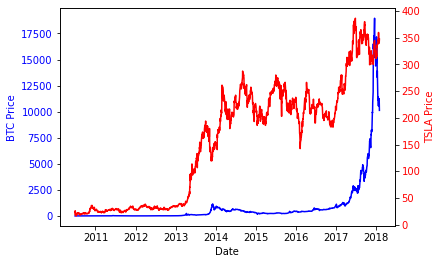

In [88]:
query = """SELECT tsla.day, tsla.price, btc.price FROM tsla, btc WHERE tsla.day = btc.day;"""
cur.execute(query)
sql_table = cur.fetchall()
df = pd.DataFrame(sql_table, columns=['day', 'tsla_price', 'btc_price'])

fig, ax1 = plt.subplots()
ax1.plot(df['day'], df['btc_price'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(df['day'], df['tsla_price'], color='red')
ax2.set_ylabel('TSLA Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

## Iran Case Study

On January 21st, 2021, the Associated Press reported on the [black cloud of smog hovering over Tehran](https://apnews.com/article/iran-media-social-media-bitcoin-coronavirus-pandemic-6d1c703a7faa1f85b0f94011259ec63e) as the power grid bore the brunt of state sanctioned Bitcoin mining. Since the United States withdrew from the colloquially-termed 'Iran Deal', the state became virtually unable to conduct with its near peers due to international sanctions. Iran, has since turned to Bitcoin as a means of trade, which has led to devastating results for the local air quality. This first began in 2018, but we seek to explore whether Iran showed previous signed of ramping up its Bitcoin production. The pollution data is reported daily, which means that we need a way of grouping the daily Bitcoin data points into yearly averages. To obtain the groupings, we use the $\texttt{EXTRACT}$ SQL command to isolate the year from the Date-time types. We then map the total amount of Bitcoins in over time against the level of air-pollution in Iran. Understandably this isn't a perfect comparison, but it is enough to see if Iran's energy expenditures have any correlation with the growing abundance of Bitcoins over time.

[[1.         0.44028654]
 [0.44028654 1.        ]]


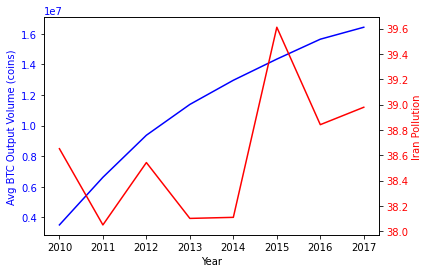

In [89]:
query = """SELECT EXTRACT(YEAR FROM day), AVG(total_btc) FROM btc GROUP BY EXTRACT(YEAR FROM day) ORDER BY EXTRACT(YEAR FROM day);"""
cur.execute(query)

btc_avg_output = cur.fetchall()
df_btc_avg_output = pd.DataFrame(btc_avg_output, columns=['year','total_btc'])

iran = df_pollution[df_pollution['country_code']=='IRN']
iran =iran.drop(columns=['country_name', 'country_code'])
iran = np.reshape(iran.to_numpy(), -1)
btc_avg_output = df_btc_avg_output['total_btc'][:-1]

fig, ax1 = plt.subplots()
ax1.plot(range(2010,2018), btc_avg_output, color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg BTC Output Volume (coins)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(2010,2018), iran, color='red')
ax2.set_ylabel('Iran Pollution', color='red')
ax2.tick_params(axis='y', labelcolor='red')

print(np.corrcoef(btc_avg_output, iran))

## Hypothesis Testing

Though there don't seem to be any obvious trends in the visualizations, we proceed to test two hypotheses using a Linear Least Squares Regressions. For this, we turn to the Sci-kit Learn python library.

### $H_0:$ There is no correlation between the price of Bitcoin and Tesla stock over time.

R^2 =  0.24338737378653552


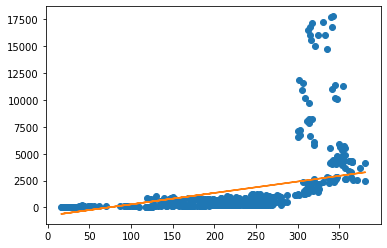

In [90]:
query = """SELECT tsla.price, btc.price FROM tsla, btc WHERE tsla.day =
btc.day"""
cur.execute(query)
sql_table = cur.fetchall()
tsla_btc = np.array(sql_table)

import sklearn
from sklearn.linear_model import LinearRegression

np.random.shuffle(tsla_btc)
Xtrain = tsla_btc[:1000, 0]
ytrain = tsla_btc[:1000,1]
Xtest = tsla_btc[1000:, 0]
ytest = tsla_btc[1000:,1]
plt.plot(Xtrain, ytrain, 'o')
m, b = np.polyfit(Xtrain, ytrain, 1)
plt.plot(Xtrain, m*Xtrain + b)
reg = LinearRegression().fit(Xtrain.reshape(-1, 1), ytrain)
print("R^2 = ", reg.score(Xtest.reshape(-1, 1), ytest))

We cannot reject the null hypothesis as there is no correlation between the price of Bitcoin and Tesla stock over time.

### $H_0: $ There is no correlation between Bitcoin mining and global air pollution over time.

R^2 =  -0.44628412430643016


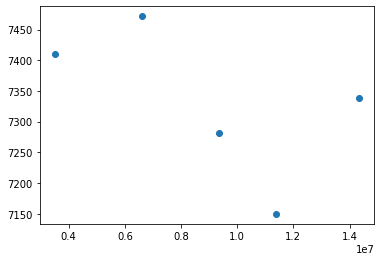

In [91]:
query = """SELECT EXTRACT(YEAR FROM day), AVG(total_btc) FROM btc GROUP BY EXTRACT(YEAR FROM day) ORDER BY EXTRACT(YEAR FROM day);"""
cur.execute(query)

total_btc = cur.fetchall()
df_total_btc = pd.DataFrame(total_btc, columns=['years','total_btc'])

df_total_pollution = pd.DataFrame(np.sum(df_pollution.iloc[:,2:], axis=0), columns=['pollution'])
df_total_pollution.reset_index(inplace=True)
df_total_pollution = df_total_pollution.rename(columns = {'index':'year'})

btc_pollution = pd.concat([df_total_pollution, df_total_btc], axis=1, join="inner")
btc_pollution = btc_pollution.drop(columns ='years')

btc_pollution = np.array(btc_pollution)
btc_pollution

import sklearn
from sklearn.linear_model import LinearRegression

np.random.shuffle(btc_pollution)
Xtrain = btc_pollution[:5, 2]
ytrain = btc_pollution[:5, 1]
Xtest = btc_pollution[4:, 2]
ytest = btc_pollution[4:, 1]
plt.plot(Xtrain, ytrain, 'o')
reg = LinearRegression().fit(Xtrain.reshape(-1, 1), ytrain)
print("R^2 = ", reg.score(Xtest.reshape(-1, 1), ytest))

We cannot reject the null hypothesis that there is no correlation between Bitcoin mining and global air pollution over time.



## Discussion

It is clear from the visualizations and the statistical tests, that the present data is not enough to establish a clear trend from the available data. This data could perhaps be even more useful if it was paired with just how much $CO_2 (ppm)$ Tesla and Bitcoin mining were expending. Also, adding more and more data on other culprits in $CO_2$ emissions could help establish the nature of the EV Manufacturer's impact, both as a perpetrator of extra consumption through novelty and as a provider of a cleaner alternative to gasoline-powered cars. Though the relationships presently appear to be non-existent, it is still interesting to visualize the chaotic and generally exponential growth of both Bitcoin and Tesla. Though less, optimistic, it is also interesting to see the rate of air-pollution throughout the past decade visualized as part of a larger narrative.

## Challenges

We encountered several challenges while working through this project. Most were typical qualitative choices that come with every data science project. For instance, we needed to decide, without first seeing the data, which columns to omit from the CSV files. It seemed intuitive that pollution might be related to Bitcoin mining difficulty and price (more difficult problems require more computing power and a more valuable commodity is more likely to attract more miners). It also seemed intuitive to keep the date-time types as a sort of a key to connect otherwise unrelated datasets.

We also ran into technical issues with schema permissions. We planned on only sharing access to particular tables without seeing a team member's full schema, but this led to errors with sharing in general. We resolved this by sharing the complete schema, but only giving granting complete access to the relevant tables. 

The biggest challenge with this project, however, stemmed from the abstract and loosely connected nature of the datasets. Time series data is notoriously hard to analyze, but this task is made all the more difficult when thousands of data points must necessarily be condensed into yearly averages. We also operated on vague intuitions and background knowledge that might have been too recent for the available data. These factors made it difficult to pose and answer sophisticated questions with state-of-the art techniques. Instead, we opted for more convincing and techically complex visuals in favor of say, neural networks.